# Distributed Differentially Private Maximum Likelihood Estimation and Online Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
from lifelines import KaplanMeierFitter, ExponentialFitter, CoxPHFitter
import time
import scipy.stats
import netgraph
from scipy.special import expit, softmax, logit
import warnings

warnings.filterwarnings("ignore")

palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

sns.set_palette(palette)

The following code constructs the communication network $A$ based on the Metropolis-Hastings weights

In [2]:
def build_network(G):
    A = nx.to_numpy_array(G).astype(np.float64)
    n = A.shape[0]

    d = A.sum(0)

    for i in range(n):
        A[i, i] = 0
        for j in range(i):
            if A[i, j] != 0:
                A[i, j] = 1.0 / max(d[i], d[j])
                A[j, i] = A[i, j]
    
    for i in range(n):
        A[i, i] = 1 - A[i, :].sum()

    return A, n

## Distributed Survival Analysis

We use the following two datasets: 

* ACTGS 175: [Kaggle Link](https://www.kaggle.com/code/gauravduttakiit/dataset-aids-clinical-trials-group-study-175)
* Cancer Study Data: [Samstein et al. (2019)](https://www.nature.com/articles/s41588-018-0312-8). 

A copy of the data is located in the `datasets/` directory.

* For the ACTGS We plot the Kaplan-Meier survival curves for ZDV (control) and ddI (treatment), as well as the log hazard ratios by fitting a proportional hazard model using the treatment variable as a regression covariate.
* For the cancer study we plot the Kaplan-Meier survival curve for three quantiles with respect to the TMB (high TMB, medimum TMB, low TMB), we plot the log hazard ratios by fitting a proportional hazard model using the treatment variables.

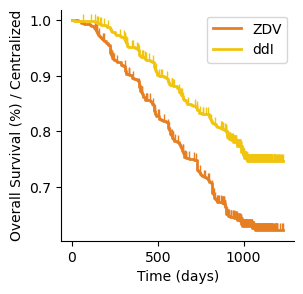

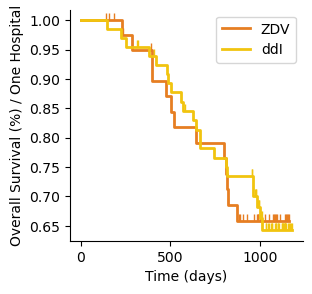

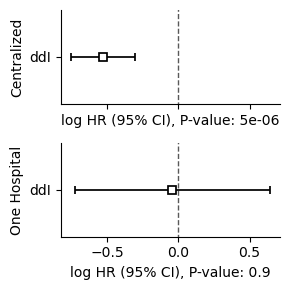

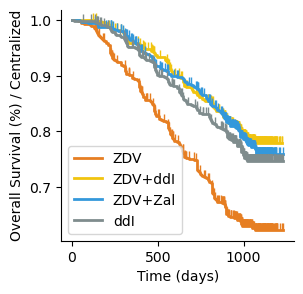

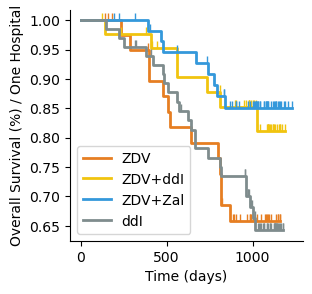

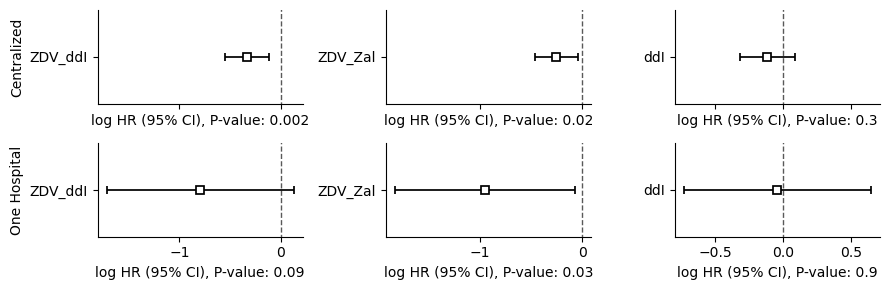

In [3]:
def load_hiv_data(control=('ZDV', 0), treatments=[('ddI', 3)]):
    df = pd.read_csv('datasets/atcg_study175/AIDS_ClinicalTrial_GroupStudy175.csv')

    all_treatments = dict([control] + treatments) 

    df = df.query(' | '.join([f'trt == {val}' for val in all_treatments.values()]))

    for key, val in all_treatments.items():
        df[key] = df['trt'] == val

    return df

def plot_hiv_data(df, num_hospitals=10, control=('ZDV', 0), treatments=[('ddI', 3)], suffix=''):

    all_treatments = dict([control] + treatments)

    df['Hospital'] = df.index % num_hospitals

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name, val in all_treatments.items():
        kmf = KaplanMeierFitter()
        df_trt = df.query(f'trt == {val}')
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=name.replace('_', '+'))
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / Centralized')
    ax.set_xlabel('Time (days)')

    fig.savefig(f'figures/survival_curves_hiv{suffix}.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    df_one_hospital = df.query('Hospital == 1')

    for name, val in all_treatments.items():
        kmf = KaplanMeierFitter()
        df_trt = df_one_hospital.query(f'trt == {val}')
        kmf.fit(durations=df_trt['time'], event_observed=df_trt['label'], label=f"{name.replace('_', '+')}")
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)

    ax.set_ylabel('Overall Survival (%) / One Hospital')
    ax.set_xlabel('Time (days)')

    fig.savefig(f'figures/survival_curves_hiv_one_hospital{suffix}.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(2, len(treatments), figsize=(3 * len(treatments), 3), sharex='col', squeeze=False)

    for i, (name, val) in enumerate(treatments):
        df_trt = df.query(f'trt == {val} | trt == {control[1]}')
        df_trt[val] = df_trt['trt'] == val

        cph = CoxPHFitter()

        cph.fit(df[['time', 'label', name]], duration_col='time', event_col='label', formula=name)

        cph.plot(ax=ax[0, i])
        
        ax[0, i].set_xlabel('log HR (95% CI), P-value: {:.1g}'.format(cph.summary.loc[name, 'p']))

        sns.despine()

        cph_hospital = CoxPHFitter()

        df_one_hospital = df_trt.query('Hospital == 1')

        cph_hospital.fit(df_one_hospital[['time', 'label', name]], duration_col='time', event_col='label', formula=name)

        cph_hospital.plot(ax=ax[1, i])

        ax[1, i].set_xlabel('log HR (95% CI), P-value: {:.1g}'.format(cph_hospital.summary.loc[name, 'p']))

        # ax[0].set_yticklabels(['Treatment'])
        # ax[1].set_yticklabels(['Treatment'])

    ax[0, 0].set_ylabel('Centralized')
    ax[1, 0].set_ylabel('One Hospital')

    fig.tight_layout()

    fig.savefig(f'figures/cox_proportional_hazard_model_hiv{suffix}.pdf', bbox_inches='tight')

df_atsg = load_hiv_data(control=('ZDV', 0), treatments=[('ddI', 3)])
plot_hiv_data(df_atsg, treatments=[('ddI', 3)])

# Treatment IDs: (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)

df_atsg_multi = load_hiv_data(control=('ZDV', 0), treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)])
plot_hiv_data(df_atsg_multi, treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)], suffix='_multi')

In [ ]:
def load_tmb_data():
    df = pd.read_excel('datasets/41588_2018_312_MOESM3_ESM.xlsx', header=1)
    df = df.sort_values(by='TMB', ascending=False)

    indices = {
        'Top 10%' : (0, int(0.1 * len(df))),
        'Top 10-20%' : (int(0.1 * len(df)), int(0.2 * len(df))),
        'Bottom 80%' : (int(0.2 * len(df)), len(df))
    }

    # Create groups based on the above indices where the indices are (start, end) pairs based on TMB values
    df['Group'] = ''

    for name, (start, end) in indices.items():
        df['Group'].iloc[start:end] = name

    print(df['Group'])


    return df

def plot_tmb_data(df, num_hospitals=5):

    df['Hospital'] = df.index % num_hospitals

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    for name in df['Group'].unique():
        df_group = df.query(f'Group == "{name}"')
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_group['SURVIVAL_MONTHS'], event_observed=df_group['SURVIVAL_EVENT'], label=name)
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)

    sns.despine()
    ax.grid(False)
    ax.set_xlim(0, 48)

    ax.set_ylabel('Overall Survival (%) / Centralized')
    ax.set_xlabel('Time (months)')

    ax.set_xticks([0, 12, 24, 36, 48])
   
    fig.savefig('figures/survival_curves_tmb.pdf', bbox_inches='tight')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    df_one_hospital = df.query('Hospital == 1')

    for name in df['Group'].unique():
        df_group = df_one_hospital.query(f'Group == "{name}" and Hospital == 1')
        kmf = KaplanMeierFitter()
        kmf.fit(durations=df_group['SURVIVAL_MONTHS'], event_observed=df_group['SURVIVAL_EVENT'], label=name)
        kmf.plot(show_censors=True, ci_show=False, censor_styles={'marker': 2, 'ms': 5}, linewidth=2)
    
    sns.despine()
    ax.grid(False)
    ax.set_xlim(0, 48)

    ax.set_ylabel('Overall Survival (%) / One Hospital')
    ax.set_xlabel('Time (months)')

    fig.savefig('figures/survival_curves_tmb_one_hospital.pdf', bbox_inches='tight')

    ax.set_xticks([0, 12, 24, 36, 48])

    cph = CoxPHFitter()

    fig, ax = plt.subplots(2, 1, figsize=(3, 3), sharex=True)

    cph.fit(df[['SURVIVAL_EVENT', 'SURVIVAL_MONTHS', 'TMB']], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')
    
    cph.plot(ax=ax[0])

    cph.fit(df_one_hospital[['SURVIVAL_EVENT', 'SURVIVAL_MONTHS', 'TMB']], duration_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', formula='TMB')

    cph.plot(ax=ax[1])

    sns.despine()

    ax[0].set_ylabel('Centralized')
    ax[1].set_ylabel('One Hospital')

    fig.tight_layout()

    fig.savefig('figures/cox_ph_tmb.pdf', bbox_inches='tight')
    
df_tmb = load_tmb_data()
plot_tmb_data(df_tmb)


## Distributed Proportional Hazards Model

### Model Description

We assume the proportional hazards model where each hospital $i$ has partial likelihood $$ \log \ell_i (\bm S_i | \theta) = \sum_{j: \bm s_{ij} = 1} \left (\bm x_{ij} \theta - \log \sum_{j' : \bm t_{ij'} \ge \bm t_{ij}} e^{\bm x_{ij'}\theta } \right ),$$

where

* $\bm s_{ij}$ is the signal (whether the patient survived or not)
* $\bm t_{ij}$ is the time the event $\bm s_{ij}$ happened
* $\bm x_{ij}$ is the covariate

In [4]:
def tvd(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def plot_beliefs_graph(G, A, beliefs, log_belief_ratios, titles, suptitle='', outfile=None, node_layout='circular', t=-1):
        
    fig, ax = plt.subplots(1, len(beliefs), figsize=(3 * len(beliefs), 3))

    cmap = plt.cm.get_cmap('Reds')

    n = len(G)

    for i, belief in enumerate(beliefs):

        node_color = {i: 'white' for i in range(n)}
        edge_color = {(i, j): cmap(A[i, j]) for i, j in G.edges()}

        node_labels = {i: f'{i + 1}\n({belief[i, t]:.2f})' for i in range(n)}
        node_label_fontdict=dict(color='black', weight='bold')

        netgraph.Graph(G, ax=ax[i], node_size=10, edge_width=1.5, node_labels=node_labels, node_label_fontdict=node_label_fontdict, node_color=node_color, edge_color=edge_color, node_layout=node_layout)

        plt.Normalize(vmin=0, vmax=1)

        ax[i].set_title(titles[i])


    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)

    fig.suptitle(suptitle)

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

def plot_beliefs_barplot(beliefs, labels, threshold, suptitle='', outfile=None, t=-1):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    records = []

    for i, (belief, label) in enumerate(zip(beliefs, labels)):
        for j in range(belief.shape[0]):
            record = {
                'Hospital' : j + 1,
                'Belief' : belief[j, t],
                'Hypothesis' : label
            }

            records.append(record)

    records = pd.DataFrame(records)

    if threshold:
        ax.axhline(threshold, color='black', linestyle='--', label='Threshold')

    sns.barplot(x='Hospital', y='Belief', hue='Hypothesis', data=records, ax=ax)

    ax.set_title(suptitle)


    ax.set_ylim([0, 1])

    sns.despine()

    fig.tight_layout()

    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')

# get the score function for the cox proportional hazard model
def get_score_function_cox(X, T, D, beta, penalizer=0):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    score = np.zeros_like(beta)

    den_sum = np.cumsum(theta[::-1])[::-1]
    num_sum = np.cumsum((X[:, 0]*theta)[::-1])[::-1]

    score = np.sum(D * (X[:, 0] - num_sum / den_sum) - penalizer * beta)

    return score

def get_log_likelihood_cox(X, T, D, beta):
    indices = np.argsort(T)

    X = X[indices]
    T = T[indices]
    D = D[indices]

    theta = np.exp(X @ beta)

    log_likelihood = 0

    temp_sum = np.cumsum(theta[::-1])[::-1] + 1e-10

        
    log_likelihood = np.sum(D * (X @ beta) - np.log(temp_sum))

    return log_likelihood


def distributed_survival_analysis(df, num_hospitals, epsilon, alpha, beta, covariate, G, time_col, event_col, alternative, rho=0.01, plot=True, node_layout='spring', suffix='', network_protection=False, method='MLE', balanced_survivals=True, generalized_lrt=False, **kwargs):    
    eta = max(alpha, 1 - beta)
    
    threshold = 1 / (1 + np.exp(rho))

    start_time = time.time()
    
    np.random.seed(0)

    if balanced_survivals:
        median = df[covariate].median()

        df_trt = df.query(f'{covariate} > {median}')
        df_ctrl = df.query(f'{covariate} <= {median}')

        df_trt['Hospital'] = df_trt.index % num_hospitals
        df_ctrl['Hospital'] = df_ctrl.index % num_hospitals

        df = pd.concat([df_trt, df_ctrl])
    else:
        df['Hospital'] = df.index % num_hospitals

    # Create a network of hospitals
    if not G:
        G = nx.complete_graph(num_hospitals)

    # Get communication matrix
    A, _ = build_network(G)
    I = np.eye(num_hospitals)

    if method in ['OL', 'Rizk-OL']:
        intermittent_period = kwargs.get('intermittent_period', 10)
        df['Period'] = df[time_col] // intermittent_period + 1
        num_iterations = df['Period'].max()
        if method == 'OL':
            log_likelihood_null_hospitals = np.zeros(shape=(num_hospitals, num_iterations))
            log_likelihood_alternative_hospitals = np.zeros(shape=(num_hospitals, num_iterations))
    elif method == 'MLE':
        log_likelihood_null_hospitals = np.zeros(num_hospitals)
        log_likelihood_alternative_hospitals = np.zeros(num_hospitals)


    Gamma_global = -np.inf
    l_global = 0
    num_hypotheses = kwargs.get('num_hypotheses', 2)
    
    # get sorted eigenvalues of A + I
    eigenvalues = np.sort(np.linalg.eigvals(A + I))[::-1]
    slem = np.max(np.abs(eigenvalues[1:]))
    alpha_star = 1/2 * slem

    if network_protection:
        Delta_global = np.max(A * (1 - np.eye(num_hospitals)))
    else:
        Delta_global = -np.inf

    start_time = time.time()

    max_covar = np.abs(df[covariate].values).max()
    max_theta = -np.inf

    cph_fits = []

    penalizer = kwargs.get('penalizer', 0.1)

    if method == 'MLE' or method.startswith('Rizk'):
        if not isinstance(alternative, np.ndarray) and alternative == 'composite':
            cph_fit_all = CoxPHFitter(penalizer=penalizer)
            cph_fit_all.fit(df[[time_col, event_col, covariate]], duration_col=time_col, event_col=event_col, formula=covariate)
            lbr_test_global = cph_fit_all.log_likelihood_ratio_test() 
            test_statistic_global = lbr_test_global.test_statistic / 2
      
        else:
            log_likelihood_null_global = get_log_likelihood_cox(df[[covariate]].values, df[time_col].values, df[event_col].values, np.zeros_like(alternative))
            log_likelihood_alternative_global = get_log_likelihood_cox(df[[covariate]].values, df[time_col].values, df[event_col].values, alternative)

            test_statistic_global = log_likelihood_alternative_global - log_likelihood_null_global
    

    for i in range(num_hospitals):
        if method == 'OL':
            for t in range(1, 1 + num_iterations):
                df_period = df[df['Period'] == t]

                log_likelihood_null_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, np.zeros_like(alternative))
                log_likelihood_alternative_hospitals[i, t-1] = get_log_likelihood_cox(df_period[[covariate]][df_period['Hospital'] == i].values, df_period[time_col][df_period['Hospital'] == i].values, df_period[event_col][df_period['Hospital'] == i].values, alternative)

                Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i, t-1]), np.abs(log_likelihood_null_hospitals[i, t-1])])
                l_global += log_likelihood_alternative_hospitals[i, t-1] - log_likelihood_null_hospitals[i, t-1]
                n_i = len(df_period)
                max_theta = max(max_theta, np.abs(alternative).max())

        elif method == 'MLE':
            if not isinstance(alternative, np.ndarray) and alternative == 'composite':
                cph_fit = CoxPHFitter(penalizer=penalizer)
                cph_fit.fit(df[[time_col, event_col, covariate]][df['Hospital'] == i], duration_col=time_col, event_col=event_col, formula=covariate)
                log_likelihood_null_hospitals[i] = cph_fit._trivial_log_likelihood()
                log_likelihood_alternative_hospitals[i] = cph_fit.log_likelihood_ratio_test().test_statistic / 2 + log_likelihood_null_hospitals[i]
                max_theta = max(max_theta, np.abs(cph_fit.summary['coef'].values[0]))

                cph_fits.append(cph_fit)
            else:
                log_likelihood_null_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, np.zeros_like(alternative))
                log_likelihood_alternative_hospitals[i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == i].values, df[time_col][df['Hospital'] == i].values, df[event_col][df['Hospital'] == i].values, alternative)
                max_theta = max(max_theta, np.abs(alternative).max())

            Gamma_global = max([Gamma_global, np.abs(log_likelihood_alternative_hospitals[i]), np.abs(log_likelihood_null_hospitals[i])])
            l_global += log_likelihood_alternative_hospitals[i] - log_likelihood_null_hospitals[i] 
            n_i = len(df[df['Hospital'] == i])
            Delta_global = max(Delta_global, n_i * (2 + np.log(n_i)))

    Delta_global = 2 * max_covar * max_theta

    l_global = np.abs(l_global)

    
    if method == 'OL':
        num_runs = 1
        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_iterations))  
    elif method == 'MLE':
        num_runs = kwargs.get('num_runs', int(np.ceil(num_hypotheses * np.log(num_hypotheses / eta))))
        log_likelihood_null_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))
        log_likelihood_alternative_hospitals_private = np.zeros(shape=(num_hospitals, num_runs))
    elif method.startswith('Rizk'):
        num_runs = 1

    for i in range(num_hospitals):
        if method == 'OL':
            for t in range(1, 1 + num_iterations):
                noise_alternative = np.random.laplace(loc=0, scale=2 * num_runs * Delta_global / epsilon)
                noise_null = np.random.laplace(loc=0, scale=2 * num_runs * Delta_global / epsilon)
                log_likelihood_alternative_hospitals_private[i, t-1] = log_likelihood_alternative_hospitals[i, t-1] + noise_alternative
                log_likelihood_null_hospitals_private[i, t-1] = log_likelihood_null_hospitals[i, t-1] + noise_null
        elif method == 'MLE':
            for j in range(num_runs):  
                noise_alternative = np.random.laplace(loc=0, scale=2 * num_runs * num_hypotheses * Delta_global / epsilon)
                noise_null = np.random.laplace(loc=0, scale=2 * num_runs * num_hypotheses * Delta_global / epsilon)
                
                log_likelihood_alternative_hospitals_private[i, j] = log_likelihood_alternative_hospitals[i] + noise_alternative
                log_likelihood_null_hospitals_private[i, j] = log_likelihood_null_hospitals[i] + noise_null

    runtime_likelihoods = time.time() - start_time

    start_time = time.time()

    if method == 'OL':
        log_belief_ratio_distributed = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals
        log_belief_ratio_private_distributed = log_likelihood_alternative_hospitals_private - log_likelihood_null_hospitals_private
    elif method == 'MLE':
        num_iterations = kwargs.get('num_iterations', int(np.ceil(num_hypotheses * max(np.log(num_hospitals / l_global), np.log((num_hypotheses * (Gamma_global + Delta_global / epsilon))/ (rho * eta)) / np.log(1 / alpha_star)))))

        log_belief_ratio_distributed = np.zeros(shape=(num_hospitals, num_iterations))
        log_belief_ratio_private_distributed = np.zeros(shape=(num_hospitals, num_runs, num_iterations))

        log_belief_ratio_distributed[:, 0] = log_likelihood_alternative_hospitals - log_likelihood_null_hospitals

        for j in range(num_runs):
            log_belief_ratio_private_distributed[:, j, 0] = log_likelihood_alternative_hospitals_private[:, j] - log_likelihood_null_hospitals_private[:, j]

    elif method.startswith('Rizk'):
        num_iterations = kwargs.get('num_iterations', 100)
        lr = kwargs.get('lr', 0.001)

        log_belief_ratio_distributed = np.zeros(shape=(num_hospitals, num_iterations))
        log_belief_ratio_private_distributed = np.zeros(shape=(num_hospitals, num_iterations))

        thetas = np.zeros(shape=(num_hospitals, num_iterations))
        thetas[:, 0] = np.random.uniform(-1, 1, size=num_hospitals)
        thetas_private = thetas.copy()
        max_theta = 1

    for i in range(1, num_iterations):
        if method == 'OL':
            log_belief_ratio_distributed[:, i] += A @ log_belief_ratio_distributed[:, i-1]
            log_belief_ratio_private_distributed[:,  i] += A @ log_belief_ratio_private_distributed[:, i-1]
        elif method == 'MLE':
            log_belief_ratio_distributed[:, i] = (A + I) @ log_belief_ratio_distributed[:, i-1]
        
            for j in range(num_runs):
                log_belief_ratio_private_distributed[:, j, i] = (A + I) @ log_belief_ratio_private_distributed[:, j, i-1]

        elif method.startswith('Rizk'):
            grad = np.zeros(num_hospitals)
            grad_private = np.zeros(num_hospitals)
            noise = np.random.laplace(loc=0, scale= lr * num_iterations * max_theta * max_covar / epsilon, size=num_hospitals)

            for j in range(num_hospitals):
                if method == 'Rizk-MLE':
                    grad[j] = get_score_function_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, thetas[j, i-1] * np.ones(1), penalizer=penalizer)
                    grad_private[j] = get_score_function_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, thetas_private[j, i-1] * np.ones(1), penalizer=penalizer)
                elif method == 'Rizk-OL':
                    df_period = df[df['Period'] == i]
                    grad[j] = get_score_function_cox(df_period[[covariate]][df_period['Hospital'] == j].values, df_period[time_col][df_period['Hospital'] == j].values, df_period[event_col][df_period['Hospital'] == j].values, thetas[j, i-1] * np.ones(1), penalizer=penalizer)
                    grad_private[j] = get_score_function_cox(df_period[[covariate]][df_period['Hospital'] == j].values, df_period[time_col][df_period['Hospital'] == j].values, df_period[event_col][df_period['Hospital'] == j].values, thetas_private[j, i-1] * np.ones(1), penalizer=penalizer)

            grad_private_norm = np.linalg.norm(grad_private, ord=1)
            grad_private = grad_private * min(1, max_theta * max_covar / grad_private_norm)

            thetas[:, i] += A @ thetas[:, i-1] + lr * grad

            thetas_private[:, i] += A @ thetas_private[:, i-1] + lr * grad_private + noise

            for j in range(num_hospitals):
                log_belief_ratio_distributed[j, i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, thetas[j, i] * np.ones(1)) - get_log_likelihood_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, np.zeros(1))
                log_belief_ratio_private_distributed[j, i] = get_log_likelihood_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, thetas_private[j, i] * np.ones(1)) - get_log_likelihood_cox(df[[covariate]][df['Hospital'] == j].values, df[time_col][df['Hospital'] == j].values, df[event_col][df['Hospital'] == j].values, np.zeros(1))
    
    runtime_communication = time.time() - start_time

    T_range = np.arange(1, num_iterations + 1)

    if method == 'OL':
        belief_null = expit(-log_belief_ratio_distributed / num_iterations)
        belief_null_private = expit(-log_belief_ratio_private_distributed / num_iterations)

        belief_alternative = 1 - belief_null
        belief_alternative_private = 1 - belief_null_private

        if plot:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Log-Belief Ratio / $t$')

            avg_log_belief_ratio_no_dp = (log_belief_ratio_distributed[:, -1] / T_range[-1]).mean()


            for i in range(num_hospitals):
                ax.plot(T_range, log_belief_ratio_private_distributed[i, :] / T_range)

            ax.axhline(avg_log_belief_ratio_no_dp, color='black', linestyle='--', label=f'Centralized ({avg_log_belief_ratio_no_dp:.2f})', linewidth=2)

            ax.legend()

            ax.set_xlim(1, num_iterations)

            ax.grid(False)
            
            ax.set_xscale('log')
            
            sns.despine()

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_ol_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            theta_labels = ['$\\theta = 0$', f'$\\theta = {alternative[0]:.2g}$']

            plot_beliefs_barplot([belief_null_private, belief_alternative_private], theta_labels, threshold=threshold, suptitle='With DP', outfile=f'figures/dp_ol{suffix}.pdf')

        tvd_ol = np.abs(belief_alternative_private[:, -1] - belief_alternative[:, -1]).mean()

        return log_belief_ratio_private_distributed, log_belief_ratio_distributed, runtime_likelihoods, runtime_communication, tvd_ol
            
    elif method == 'MLE':
        belief_alternative_global = expit(test_statistic_global)

        log_belief_ratio_private_distributed_geometric_mean = log_belief_ratio_private_distributed.mean(1)

        belief_null = expit(-log_belief_ratio_distributed)
        belief_null_private = expit(-log_belief_ratio_private_distributed)

        belief_null_private_geometric_mean = expit(-log_belief_ratio_private_distributed_geometric_mean)
        belief_null_private_arithmetric_mean = belief_null_private.mean(1)

        belief_alternative = 1 - belief_null
        belief_alternative_private_geometric_mean = 1 - belief_null_private_geometric_mean
        belief_alternative_private_arihtmetic_mean = 1 - belief_null_private_arithmetric_mean
        belief_alternative_private = 1 - belief_null_private

        log_belief_ratio_private_distributed_arithmetic_mean = np.log(belief_null_private_arithmetric_mean / belief_alternative_private_arihtmetic_mean)

        belief_null_private_count = (belief_null_private > 0).mean(1)
        belief_alternative_private_count = (belief_alternative_private > 0).mean(1)

        log_belief_ratio_private_distributed_count = np.log(belief_null_private_count / belief_alternative_private_count)

        # recovery of sets 

        theta_gm_alternative = belief_alternative_private_geometric_mean[:, -1] > threshold
        theta_gm_null = belief_null_private_geometric_mean[:, -1] > threshold

        theta_am_alternative = belief_alternative_private_arihtmetic_mean[:, -1] > threshold
        theta_am_null = belief_null_private_arithmetric_mean[:, -1] > threshold

        # GM should recover a subset of {1}: {} -> 1, {1} -> 1, {0} -> 0, {1, 0} -> 0
        type_1_gm = 1 - ((theta_gm_alternative & ~theta_gm_null) | (~theta_gm_alternative & ~theta_gm_null)).mean()

        # AM should always recover a superset of {1} : {} -> 0, {1} -> 1, {0} -> 0, {1, 0} -> 1
        type_2_am = 1 - ((theta_am_alternative & ~theta_am_null) | (theta_am_alternative & theta_am_null)).mean()

        tvd_gm = np.abs(belief_alternative_private_geometric_mean[:, -1] - belief_alternative[:, -1]).mean()
        tvd_am = np.abs(belief_alternative_private_arihtmetic_mean[:, -1] - belief_alternative[:, -1]).mean()
        tvd_count = np.abs(belief_alternative_private_count - belief_alternative).mean()

        if plot:
            
            fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False, sharey=True)

            ax[0, 0].set_title(f'Geometric Mean')
            ax[0, 1].set_title(f'Arithmetic Mean')
            
            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            tvd_no_dp = tvd(belief_alternative, belief_alternative_global).mean()
        
            for i in range(num_hospitals):
                ax[0, 0].plot(T_range, np.abs(belief_alternative_private_geometric_mean[i, :] - belief_alternative_global))
                ax[0, 1].plot(T_range, np.abs(belief_alternative_private_arihtmetic_mean[i, :] - belief_alternative_global))

            ax[0, 0].set_xlim(1, num_iterations)
            ax[0, 1].set_xlim(1, num_iterations)

            # handles, labels = ax[0, 1].get_legend_handles_labels()
            # fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=1)

            ax[0, 1].legend()

            ax[0, 0].grid(False)
            sns.despine()
            ax[0, 1].grid(False)
            sns.despine()
            
            ax[0, 0].set_xscale('log')
            ax[0, 1].set_xscale('log')

            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=True)


            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            for i in range(num_hospitals):
                ax.plot(T_range, np.abs(belief_alternative_private_count[i, :] - 1))

            ax.set_xlim(1, num_iterations)
            ax.grid(False)
            sns.despine()

            ax.set_xscale('log')
        
            fig.tight_layout()

            fig.savefig(f'figures/distributed_cox_regression_count_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            if not isinstance(alternative, np.ndarray) and alternative == 'composite':
                theta_labels = ['$\\tilde \\Theta_0$', '$\\tilde \\Theta_1$']
            else:
                theta_labels = ['$\\theta = 0$', f'$\\theta = {alternative[0]:.2g}$']


            plot_beliefs_barplot([belief_null_private_geometric_mean, belief_alternative_private_geometric_mean], theta_labels, threshold, suptitle=f'Geometric Mean', outfile=f'figures/geometric_mean{suffix}.pdf')
            plot_beliefs_barplot([belief_null_private_arithmetric_mean, belief_alternative_private_arihtmetic_mean], theta_labels, threshold, suptitle=f'Arithmetic Mean', outfile=f'figures/arithmetic_mean{suffix}.pdf')
            plot_beliefs_barplot([belief_null_private_count, belief_alternative_private_count], theta_labels, threshold, suptitle='Two Threshold', outfile=f'figures/count{suffix}.pdf')
            plot_beliefs_barplot([belief_null, belief_alternative], theta_labels, threshold, suptitle='No DP', outfile=f'figures/nodp{suffix}.pdf')

        return log_belief_ratio_private_distributed, log_belief_ratio_distributed, runtime_likelihoods, runtime_communication, tvd_gm, tvd_am, tvd_count, type_1_gm, type_2_am

    elif method.startswith('Rizk'):
        belief_alternative_global = expit(test_statistic_global)
    
        belief_null_private = expit(-log_belief_ratio_private_distributed)
        belief_alternative_private = 1 - belief_null_private

        belief_null = expit(-log_belief_ratio_distributed)
        belief_alternative = 1 - belief_null

        tvd_rizk = np.abs(belief_alternative_private[:, -1] - belief_alternative[:, -1]).mean()

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
            T_range = np.arange(1, num_iterations + 1)

            for i in range(num_hospitals):
                ax[0].plot(T_range, thetas[i, :])
                ax[1].plot(T_range, thetas_private[i, :])

            ax[0].set_ylabel('No DP')
            sns.despine()
            ax[1].set_ylabel('With DP')
            sns.despine()

            ax[0].set_xlim(1, num_iterations)
            ax[1].set_xlim(1, num_iterations)

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Parameter Values $\\theta_{i, t}$')

            fig.tight_layout()

            fig.savefig(f'figures/rizk_parameters_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')

            fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        
            for i in range(num_hospitals):
                ax[0].plot(T_range, np.abs(belief_alternative[i, :] - belief_alternative_global))
                ax[1].plot(T_range, np.abs(belief_alternative_private[i, :] - belief_alternative_global))

            ax[0].set_ylabel('No DP')
            sns.despine()
            ax[1].set_ylabel('With DP')
            sns.despine()   

            ax[0].set_xlim(1, num_iterations)
            ax[1].set_xlim(1, num_iterations)

            fig.supxlabel('Iteration (t)')
            fig.supylabel('Total Variation Distance')

            fig.tight_layout()

            fig.savefig(f'figures/rizk_tvd_{num_hospitals}_{epsilon}_{eta}{suffix}.pdf', bbox_inches='tight')


        return log_belief_ratio_private_distributed, log_belief_ratio_distributed, runtime_likelihoods, runtime_communication, tvd_rizk


def likelihood_ratio_test(df, num_hospitals, epsilon, alpha, covariate, G, time_col, event_col, bootstrap=False, balanced_survivals=False, suffix='', **kwargs):
    
    # Centralized test
    cph_fit_all = CoxPHFitter(penalizer=0.1)
    cph_fit_all.fit(df[[time_col, event_col, covariate]], duration_col=time_col, event_col=event_col, formula=covariate)

    lbr_test_centralized = cph_fit_all.log_likelihood_ratio_test()

    lbr_centralized = lbr_test_centralized.test_statistic

    p_value_centralized = lbr_test_centralized.p_value

    threshold_centralized = scipy.stats.chi2.ppf(1 - alpha, 1)

    if bootstrap:
        num_null_samples = kwargs.get('num_null_samples', int(np.ceil(1.1 / alpha)))
        log_belief_ratios_private_distributed_geometric_mean_null = np.zeros((num_hospitals, num_null_samples))
        frac = kwargs.get('frac', 0.5)

        # Calculate p-values
        cph_fit_all_null = CoxPHFitter()
        cph_fit_all_null.fit(df[[time_col, event_col]], duration_col=time_col, event_col=event_col)
        baseline_hazard_rate = cph_fit_all_null.baseline_hazard_.values[0]

        for i in range(num_null_samples):
            df_null = df.copy().sample(frac=frac, replace=True)

            U = np.random.uniform(size=len(df_null))

            df_null['time'] = -np.log(U) / baseline_hazard_rate

            log_belief_ratio_private_distributed_null, _, _, _, _, _, _, _, _ = distributed_survival_analysis(df_null, num_hospitals, epsilon, alpha/2, 1 - alpha/2, covariate=covariate, G=G, time_col=time_col, event_col=event_col, alternative='composite', rho=1, plot=False, suffix=suffix, balanced_survivals=balanced_survivals)

            log_belief_ratios_private_distributed_geometric_mean_null[:, i] = num_hospitals / 2**(1 + log_belief_ratio_private_distributed_null.shape[-1]) * log_belief_ratio_private_distributed_null.mean(1)[:, -1]

        threshold_distributed = np.percentile(log_belief_ratios_private_distributed_geometric_mean_null.flatten(), 100 * (1 - alpha / 2))
    else:
        threshold_distributed = scipy.stats.chi2.ppf(1 - alpha / 2, num_hospitals) - 1

    log_belief_ratio_private_distributed, log_belief_ratio_distributed, _, _, _, _, _, _, _ = distributed_survival_analysis(df, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha/2, beta=1 - alpha/2, covariate=covariate, G=G, time_col=time_col, event_col=event_col, alternative='composite', rho=1, plot=False, suffix=suffix, balanced_survivals=balanced_survivals)

    log_belief_ratio_private_distributed_geometric_mean = num_hospitals / 2**(log_belief_ratio_private_distributed.shape[-1]) * log_belief_ratio_private_distributed.mean(1)[:, -1]
    log_belief_ratio_distributed = num_hospitals / 2**(log_belief_ratio_distributed.shape[-1]) * log_belief_ratio_distributed[:, -1]

    p_values = np.zeros(num_hospitals)

    for i in range(num_hospitals):
        if bootstrap:
            p_values[i] = np.mean(log_belief_ratios_private_distributed_geometric_mean_null[i, :] > log_belief_ratio_private_distributed_geometric_mean[i])
        else:
            p_values[i] = 1 - scipy.stats.chi2.cdf(log_belief_ratio_private_distributed_geometric_mean[i] + 1, num_hospitals)

    print(f'Decentralized test: Test statistics = {log_belief_ratio_private_distributed_geometric_mean}, No DP statistics: {log_belief_ratio_distributed}, Threshold (alpha = {alpha}) = {threshold_distributed}, P-values = {p_values}')
    print(f'Centralized test: Test statistic = {lbr_centralized}, Threshold (alpha = {alpha}) = {threshold_centralized}, P-value: {p_value_centralized}')

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    sns.histplot(p_values, ax=ax[0], kde=True)
    ax[0].set_title('P-values')
    sns.despine()

    sns.histplot(log_belief_ratio_private_distributed_geometric_mean, ax=ax[1], kde=True)
    ax[1].set_title('Test Statistics')
    sns.despine()

    fig.tight_layout()




### Beliefs plot

We plot the results of distributed MLE and OL for the two datasets

In [ ]:
# ATSG
num_hospitals = 5
alpha = 0.05
beta = 1 - alpha
epsilon = 1
G = nx.complete_graph(num_hospitals)

# Hypothesis Test
# Generalized LRT
_ = likelihood_ratio_test(df_atsg, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, covariate='ddI', G=G, time_col='time', event_col='label', suffix='_hiv_erdosrenyi', alternative='composite', bootstrap=False)

# MLE
simple_alternative = np.log(1/2) * np.ones(1)
_ = distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=G, epsilon=epsilon, alpha=alpha, beta=beta, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=simple_alternative, method='MLE', rho=1.5)
_ = distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=G, epsilon=epsilon, alpha=alpha, beta=beta, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative=simple_alternative, method='OL', intermittent_period=10)

# MLE Rizk et al (2023)
_ = distributed_survival_analysis(df_atsg, num_hospitals=num_hospitals, G=G, epsilon=epsilon, alpha=alpha, beta=beta, covariate='ddI', node_layout='spring', suffix='_hiv_erdosrenyi', time_col='time', event_col='label', alternative='composite', method='Rizk-MLE', num_iterations=100, lr=0.001, penalizer=0.1)


# TMB

# Hypothesis Test
# Generalized LRT
_ = likelihood_ratio_test(df_tmb, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, covariate='TMB', G=G, time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', suffix='_tmb_erdosrenyi', bootstrap=False, balanced_survivals=False)

# MLE
simple_alternative = np.log(0.15) * np.ones(1)
distributed_survival_analysis(df_tmb, num_hospitals=num_hospitals, G=G, epsilon=epsilon, alpha=alpha, beta=beta, covariate='TMB', node_layout='spring', suffix='_tmb_erdosrenyi', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=simple_alternative, balanced_survivals=False)
distributed_survival_analysis(df_tmb, num_hospitals=num_hospitals, G=G, epsilon=epsilon, alpha=alpha, beta=beta, covariate='TMB', node_layout='spring', suffix='_tmb_erdosrenyi', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=simple_alternative, method='OL', intermittent_period=1, balanced_survivals=False)

### Best Treatmnent Identification for the AIDS Data (Multi-hypothesis testing)

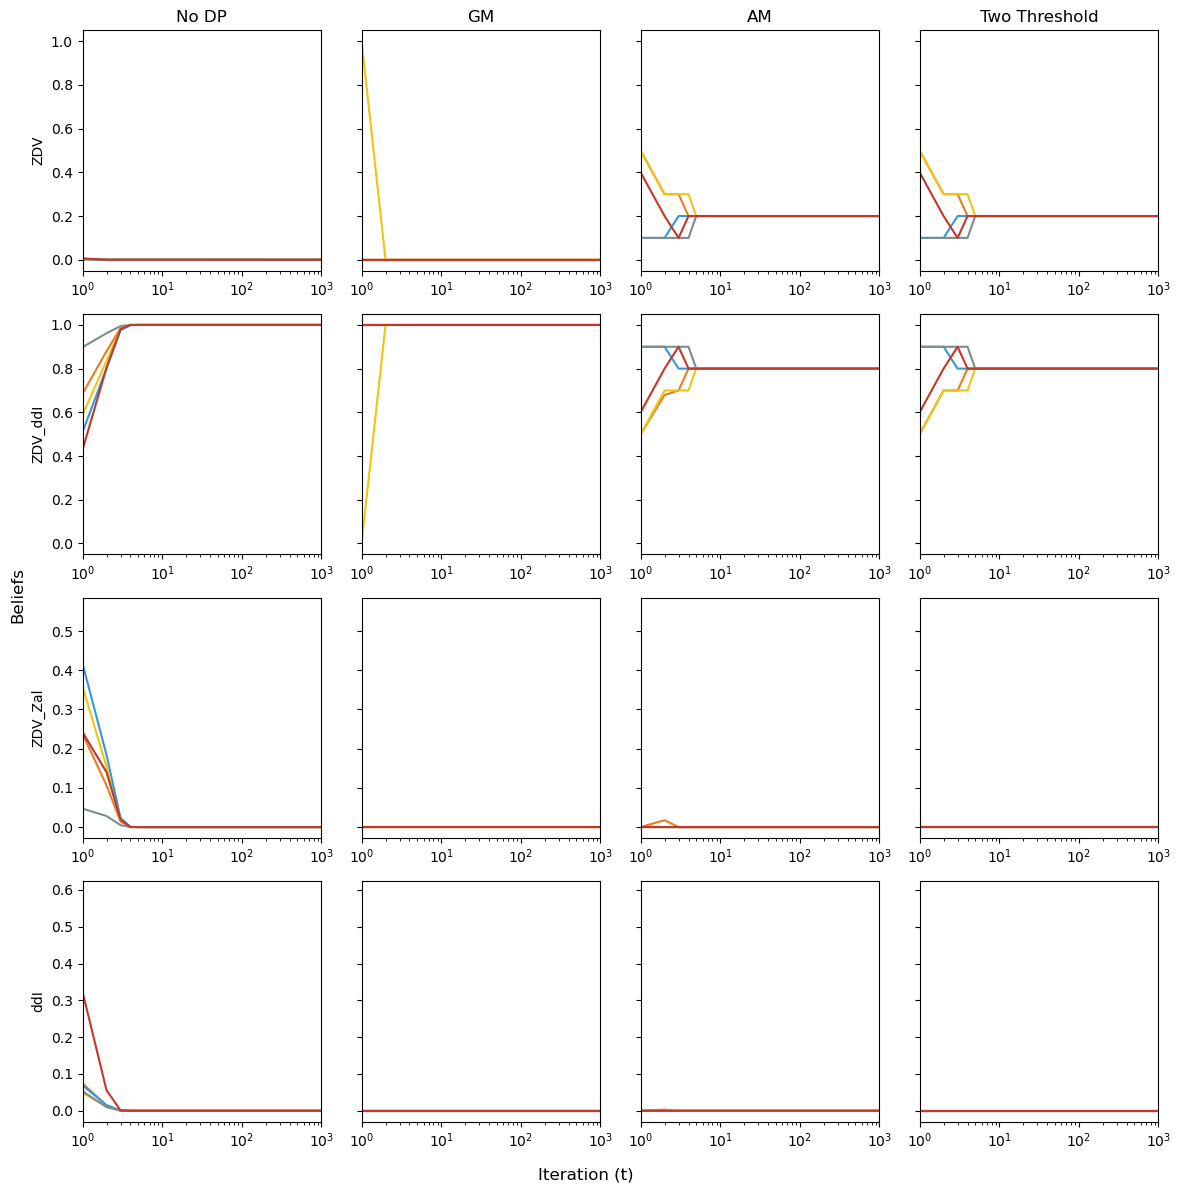

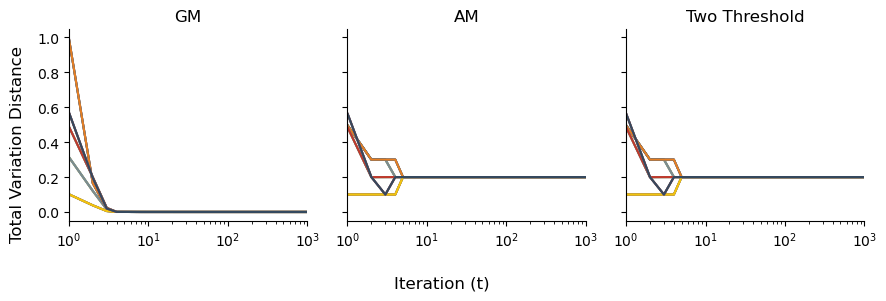

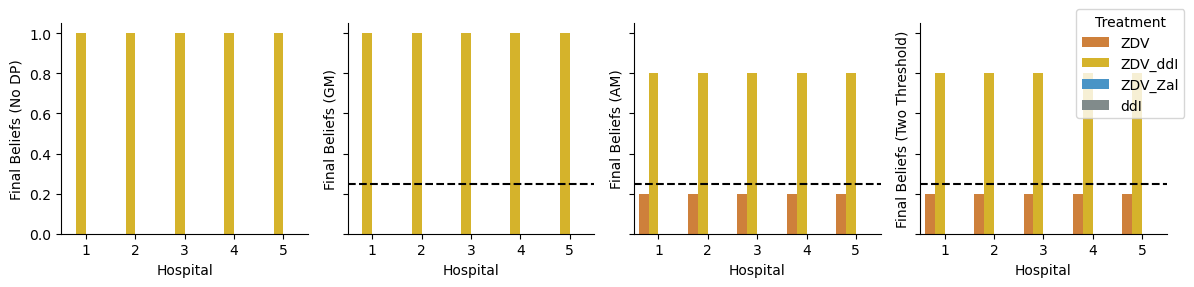

In [32]:
def to_beliefs(x):
    # add one 0 in the start
    x = np.concatenate([np.zeros(1), x])
    x = softmax(x)
    x /= x.sum()
    return x

def distributed_survival_analysis_multi(df, num_hospitals, epsilon, alpha, beta, control, treatments, G, time_col, event_col, alternative, rho=0.01, method='MLE', num_iterations=1000, num_runs=10, suffix='', intermittent_period=1):

    threshold = 1 / (1 + np.exp(rho))

    log_belief_ratio_private_distributed_treatments = []
    log_belief_ratio_distributed_treatments = []

    T_min = np.inf
    T_max = -np.inf

    A, n = build_network(G)

    for name, val in treatments:
        df_trt = df.query(f'trt == {val} | trt == {control[1]}')
        if method == 'OL':
            log_belief_ratio_private_distributed, log_belief_ratio_distributed, _, _, _ = distributed_survival_analysis(df=df_trt, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, beta=beta, covariate=name, G=G, time_col=time_col, event_col=event_col, alternative=alternative, rho=rho, plot=False, method=method, num_iterations=num_iterations, num_runs=num_runs, intermittent_period=intermittent_period)
            T_min = min(T_min, log_belief_ratio_private_distributed.shape[-1])
            T_max = max(T_max, log_belief_ratio_private_distributed.shape[-1])
        else:
            log_belief_ratio_private_distributed, log_belief_ratio_distributed, _, _, _, _, _, _, _ = distributed_survival_analysis(df=df_trt, num_hospitals=num_hospitals, epsilon=epsilon, alpha=alpha, beta=beta, covariate=name, G=G, time_col=time_col, event_col=event_col, alternative=alternative, rho=rho, plot=False, method=method, num_iterations=num_iterations, num_runs=num_runs)
            T_min = num_iterations
            T_max = num_iterations

        log_belief_ratio_private_distributed_treatments.append(log_belief_ratio_private_distributed)
        log_belief_ratio_distributed_treatments.append(log_belief_ratio_distributed)

    if method == 'OL':
        temp_array = []
        temp_private_array = []
        
        for j in range(len(treatments)):
            temp = np.zeros((num_hospitals, T_max))
            temp_private = np.zeros((num_hospitals, T_max))
            log_belief_ratio_distributed = log_belief_ratio_distributed_treatments[j]
            log_belief_ratio_private_distributed = log_belief_ratio_private_distributed_treatments[j]

            for t in range(T_max):
                if t <= log_belief_ratio_distributed.shape[-1] - 1:
                    temp[ :, t] = log_belief_ratio_private_distributed[ :, t]
                    temp_private[ :, t] = log_belief_ratio_distributed[:, t]
                else:
                    temp[:, t] = A @ temp[:, t-1]
                    temp_private[:, t] = A @ temp_private[:, t-1]

            temp_array.append(temp)
            temp_private_array.append(temp_private)

        log_belief_ratio_private_distributed_treatments = np.array(temp_private_array)
        log_belief_ratio_distributed_treatments = np.array(temp_array)

    else:
        log_belief_ratio_private_distributed_treatments = np.array(log_belief_ratio_private_distributed_treatments)
        log_belief_ratio_distributed_treatments = np.array(log_belief_ratio_distributed_treatments)

    records = []

    if method == 'OL':
        ncols = 2
    else:
        ncols = 4

    fig, ax = plt.subplots(1 + len(treatments), ncols, figsize=(3 * ncols, 3 * (1 + len(treatments))), sharey='row')

    fig_tvd, ax_tvd = plt.subplots(1, ncols - 1, figsize=(3 * (ncols - 1), 3), sharey=True, squeeze=False)

    fig.supxlabel('Iteration (t)')
    fig.supylabel('Beliefs')

    fig_tvd.supxlabel('Iteration (t)')
    fig_tvd.supylabel('Total Variation Distance')

    if method == 'OL':
        ax[0, 0].set_title('No DP')
        ax[0, 1].set_title('OL')

        ax_tvd[0, 0].set_title('OL')

    else:
        ax[0, 0].set_title('No DP')
        ax[0, 1].set_title('GM')
        ax[0, 2].set_title('AM')
        ax[0, 3].set_title('Two Threshold')

        ax_tvd[0, 0].set_title('GM')
        ax_tvd[0, 1].set_title('AM')
        ax_tvd[0, 2].set_title('Two Threshold')


    for j, (name, val) in enumerate([control] + treatments):
        ax[j, 0].set_ylabel(name)

        for k in range(ncols):
            ax[j, k].set_xlim(1, T_max)
            ax[j, k].set_xscale('log')
            sns.despine()

    for k in range(ncols - 1):
        ax_tvd[0, k].set_xlim(1, T_max)
        ax_tvd[0, k].set_xscale('log')

        sns.despine()

    for i in range(num_hospitals):

        beliefs = np.apply_along_axis(to_beliefs, 0, log_belief_ratio_distributed_treatments[:, i, :])

        if method == 'OL':
            beliefs_private = np.apply_along_axis(to_beliefs, 0, log_belief_ratio_private_distributed_treatments[:, i, :])
        else:
            beliefs_private_gm = np.apply_along_axis(to_beliefs, 0, log_belief_ratio_private_distributed_treatments[:, i, :, :].mean(-2))

            beliefs_private_am = np.zeros_like(beliefs_private_gm)
            beliefs_private_count = np.zeros_like(beliefs_private_gm)

            for k in range(num_runs):
                beliefs_tmp = np.apply_along_axis(to_beliefs, 0, log_belief_ratio_private_distributed_treatments[:, i, k, :])
                beliefs_private_am += beliefs_tmp

                beliefs_private_count += (beliefs_tmp > threshold).astype(np.float64)

            beliefs_private_am /= num_runs
            beliefs_private_count /= num_runs

        for j, (name, val) in enumerate([control] + treatments):
            record = {
                'Hospital' : i + 1,
                'Treatment' : name,
                'Final Beliefs (No DP)' : beliefs[j, -1],
            }

            if method == 'OL':
                record['Final Beliefs (DP)'] = beliefs_private[j, -1]

                ax[j, 0].plot(beliefs[j, :])
                ax[j, 1].plot(beliefs_private[j, :])

                tvd_ol = 0.5 * np.abs(beliefs_private - beliefs).sum(0)

                ax_tvd[0, 0].plot(tvd_ol)
            else:
                record['Final Beliefs (GM)'] = beliefs_private_gm[j, -1]
                record['Final Beliefs (AM)'] = beliefs_private_am[j, -1]
                record['Final Beliefs (Two Threshold)'] = beliefs_private_count[j, -1]

                ax[j, 0].plot(beliefs[j, :])
                ax[j, 1].plot(beliefs_private_gm[j, :])
                ax[j, 2].plot(beliefs_private_am[j, :])
                ax[j, 3].plot(beliefs_private_count[j, :])

                tvd_gm = 0.5 * np.abs(beliefs_private_gm - beliefs).sum(0)
                tvd_am = 0.5 * np.abs(beliefs_private_am - beliefs).sum(0)
                tvd_count = 0.5 * np.abs(beliefs_private_count - beliefs).sum(0)

                ax_tvd[0, 0].plot(tvd_gm)
                ax_tvd[0, 1].plot(tvd_am)
                ax_tvd[0, 2].plot(tvd_count)

           

            records.append(record)

    records = pd.DataFrame(records)

    fig.tight_layout()

    fig.savefig(f'figures/final_beliefs_trajectory_multi{suffix}.pdf', bbox_inches='tight')

    fig_tvd.tight_layout()

    fig_tvd.savefig(f'figures/tvd_trajectory_multi{suffix}.pdf', bbox_inches='tight')

    if method == 'OL':
        fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
        sns.barplot(x='Hospital', y='Final Beliefs (No DP)', hue='Treatment', data=records, ax=ax[0])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (DP)', hue='Treatment', data=records, ax=ax[1])
        sns.despine()

        ax[0].legend().remove()

        # move legend
        ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        
        fig.tight_layout()
        fig.savefig(f'figures/final_beliefs_multi_ol{suffix}.pdf', bbox_inches='tight')
    else:
        fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

        sns.barplot(x='Hospital', y='Final Beliefs (No DP)', hue='Treatment', data=records, ax=ax[0])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (GM)', hue='Treatment', data=records, ax=ax[1])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (AM)', hue='Treatment', data=records, ax=ax[2])
        sns.despine()
        sns.barplot(x='Hospital', y='Final Beliefs (Two Threshold)', hue='Treatment', data=records, ax=ax[3])
        sns.despine()

        ax[1].axhline(threshold, color='black', linestyle='--', label='Threshold')
        ax[2].axhline(threshold, color='black', linestyle='--', label='Threshold')
        ax[3].axhline(threshold, color='black', linestyle='--', label='Threshold')

        # remove legend
        ax[0].legend().remove()
        ax[1].legend().remove()
        ax[2].legend().remove()

        sns.move_legend(ax[3], "upper right", bbox_to_anchor=(1.1, 1.1))

        fig.tight_layout()

        fig.savefig(f'figures/final_beliefs_multi{suffix}.pdf', bbox_inches='tight')

thres = 0.25
rho = np.log(1/thres - 1)
num_hospitals = 5

distributed_survival_analysis_multi(df_atsg_multi, num_hospitals=num_hospitals, epsilon=0.1, alpha=0.05, beta=0.95, control=('ZDV', 0), treatments=[('ZDV_ddI', 1), ('ZDV_Zal', 2), ('ddI', 3)], G=nx.complete_graph(num_hospitals), time_col='time', event_col='label', alternative='composite', rho=rho)


### Runtime plots

In [ ]:
def plot_runtime(df, covariate, time_col, event_col, alternative, penalizer=0, suffix=''):

    num_hospitals_range = 3 * 2**np.arange(1, 6)

    df_4096 = df.sample(n=4096, replace=True)
    df_8192 = df.sample(n=8192, replace=True)

    df_10xdataset = pd.concat([df_4096] * 10)

    records = []

    for num_hospitals in num_hospitals_range:
        print(f'n = {num_hospitals}')
        _, _, runtime_likelihoods_4096, runtime_communication_4096, _, _, _, _, _ = distributed_survival_analysis(df_4096, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, penalizer=penalizer)
        _, _, runtime_likelihoods_8192, runtime_communication_8192, _, _, _, _, _ = distributed_survival_analysis(df_8192, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, penalizer=penalizer)
        _, _, runtime_likelihoods_10xdataset, runtime_communication_10xdataset, _, _, _, _, _ = distributed_survival_analysis(df_10xdataset, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=0.1, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, penalizer=penalizer)

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_4096,
            'Initialization Runtime (s)' : runtime_likelihoods_4096,
            'Total Runtime (s)' : runtime_communication_4096 + runtime_likelihoods_4096,
            't.p.' : '4096'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_8192,
            'Initialization Runtime (s)' : runtime_likelihoods_8192,
            'Total Runtime (s)' : runtime_communication_8192 + runtime_likelihoods_8192,
            't.p.' : '8192'
        })

        records.append({
            'Number of Data Providers' : num_hospitals,
            'Communication Runtime (s)' : runtime_communication_10xdataset,
            'Initialization Runtime (s)' : runtime_likelihoods_10xdataset,
            'Total Runtime (s)' : runtime_communication_10xdataset + runtime_likelihoods_10xdataset,
            't.p.' : '10x dataset'
        })
        
    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    sns.barplot(x='Number of Data Providers', y='Communication Runtime (s)', data=records, hue='t.p.', ax=ax[1])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Initialization Runtime (s)', data=records, hue='t.p.', ax=ax[0])
    sns.despine()
    sns.barplot(x='Number of Data Providers', y='Total Runtime (s)', data=records, hue='t.p.', ax=ax[2])
    sns.despine()

    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    # remove legend
    ax[0].legend().remove()
    ax[1].legend().remove()

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')

    fig.supxlabel('Number of Data Providers')

    fig.tight_layout()

    fig.savefig(f'figures/runtime{suffix}.pdf', bbox_inches='tight')

plot_runtime(df_atsg, suffix='_atsg', covariate='ddI', time_col='time', event_col='label', alternative=np.log(1/2) * np.ones(1))
plot_runtime(df_atsg, suffix='_atsg_composite', covariate='ddI', time_col='time', event_col='label', alternative='composite', penalizer=0.1)

plot_runtime(df_tmb, suffix='_tmb', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative=np.log(0.15) * np.ones(1))
plot_runtime(df_tmb, suffix='_tmb_composite', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', alternative='composite', penalizer=0.1)

### Error vs. privacy budget plots

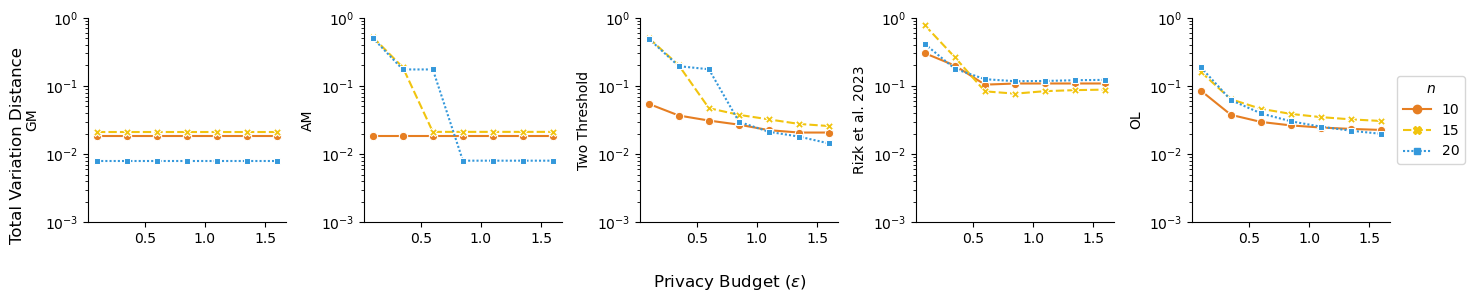

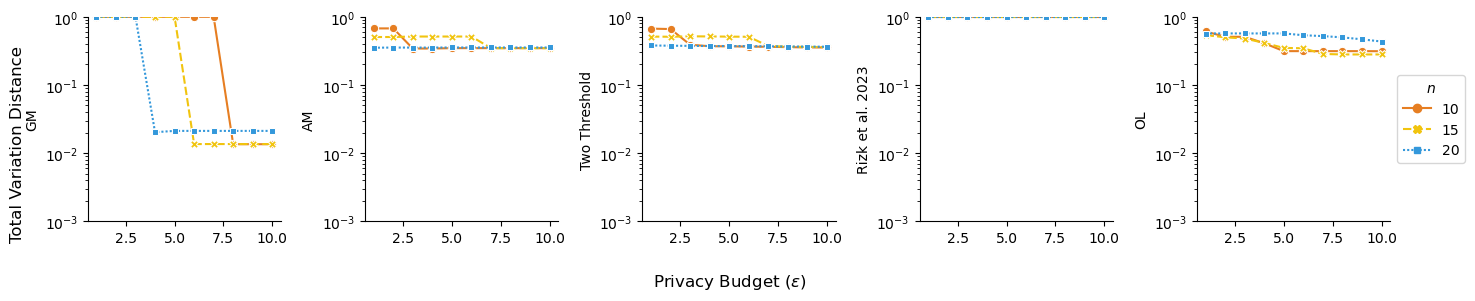

In [19]:
def plot_errors(df, alternative, suffix='', covariate='ddI', time_col='time', event_col='label', eps_min=0.1, eps_max=1.5, eps_step=0.1):

    num_hospitals_range = [10, 15, 20]

    eps_range = np.arange(eps_min, eps_max + eps_step, eps_step)
    records = []

    min_tvd_gm, max_tvd_gm = np.inf, -np.inf
    min_tvd_am, max_tvd_am = np.inf, -np.inf

    for num_hospitals in num_hospitals_range:
        for eps in eps_range:    
            lbr, _, _, _, tvd_gm, tvd_am, tvd_count, _, _ = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='_tmb_star', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, rho=0.1)
            _, _, _, _, tvd_ol = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='_tmb_star_ol', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, rho=0.1, method='OL', intermittent_period=10)
            
            T = lbr.shape[-1]
            
            _, _, _, _, tvd_rizk = distributed_survival_analysis(df, num_hospitals=num_hospitals, G=nx.complete_graph(num_hospitals), epsilon=eps, alpha=0.1, beta=0.9, covariate=covariate, node_layout='dot', suffix='_tmb_star_rizk', time_col=time_col, event_col=event_col, alternative=alternative, plot=False, rho=0.1, method='Rizk-MLE', num_iterations=T, lr=0.001, penalizer=0.1)

            jitter = np.random.uniform(0, 0.05)

            records.append({
                'Number of Data Providers ($n$)' : num_hospitals,
                'Privacy Budget ($\epsilon$)' : eps,
                'Total Variation Distance (GM)' : max(0, min(1, tvd_gm + jitter)),
                'Total Variation Distance (AM)' : max(0, min(1, tvd_am + jitter)),
                'Total Variation Distance (Count)' : max(0, min(1, tvd_count + jitter)),
                'Total Variation Distance (OL)' : max(0, min(1, tvd_ol + jitter)),
                'Total Variation Distance (Rizk et al. 2023)' : max(0, min(1, tvd_rizk + jitter)),
            })


    records = pd.DataFrame(records)

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))

    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (GM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[0], markers=True, legend=False, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (AM)', data=records, hue='Number of Data Providers ($n$)', ax=ax[1], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (Count)', data=records, hue='Number of Data Providers ($n$)', ax=ax[2], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (Rizk et al. 2023)', data=records, hue='Number of Data Providers ($n$)', ax=ax[3], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], legend=False, style='Number of Data Providers ($n$)')
    sns.despine()
    sns.lineplot(x='Privacy Budget ($\epsilon$)', y='Total Variation Distance (OL)', data=records, hue='Number of Data Providers ($n$)', ax=ax[4], markers=True, palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'], style='Number of Data Providers ($n$)')
    sns.despine()

    ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='$n$')

    fig.tight_layout()

    fig.savefig(f'figures/tvd_errors{suffix}.pdf', bbox_inches='tight')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')
    ax[3].set_xlabel('')
    ax[4].set_xlabel('')

    ax[0].set_ylim(1e-3, 1)
    ax[1].set_ylim(1e-3, 1)
    ax[2].set_ylim(1e-3, 1)
    ax[3].set_ylim(1e-3, 1)
    ax[4].set_ylim(1e-3, 1)

    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[3].set_yscale('log')
    ax[4].set_yscale('log')

    ax[0].set_ylabel('GM')
    ax[1].set_ylabel('AM')
    ax[2].set_ylabel('Two Threshold')
    ax[3].set_ylabel('Rizk et al. 2023')
    ax[4].set_ylabel('OL')

    fig.supxlabel('Privacy Budget ($\epsilon$)')
    fig.supylabel('Total Variation Distance')

    fig.tight_layout()

    fig.savefig(f'figures/tvd_errors{suffix}.pdf', bbox_inches='tight')

  
plot_errors(df_atsg, eps_min=0.1, eps_max=1.5, eps_step=0.25, alternative=np.log(1/2) * np.ones(1), suffix='_atsg', covariate='ddI', time_col='time', event_col='label')
plot_errors(df_tmb, suffix='_tmb', covariate='TMB', time_col='SURVIVAL_MONTHS', event_col='SURVIVAL_EVENT', eps_min=1, eps_max=10, eps_step=1, alternative=np.log(0.15) * np.ones(1))

## Critical Thresholds for Data Sharing

The following code reproduces the figures used in the example presented in the paper. 

### Randomized Response Mechanism

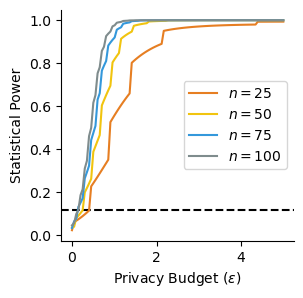

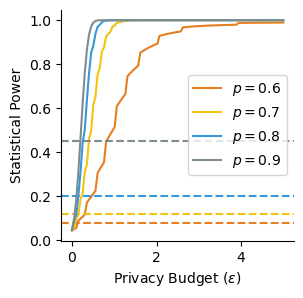

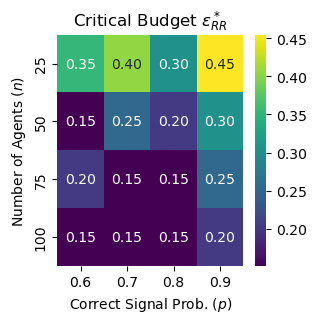

In [20]:
import scipy.stats

def binary_signal_statistical_power_individual(p, alpha):
    if 1 - p < alpha:
        return p + (1 - p) * (alpha - 1 + p) / p
    elif 1 - p == alpha:
        return p
    else:
        return p * alpha / (1 - p)

def binary_signals_statistical_power_rr(n, p, epsilon, alpha=0.05):

    p_eps = 1 / (1 + np.exp(epsilon))

    q = p * p_eps + (1 - p) * (1 - p_eps)

    threshold = scipy.stats.binom.isf(alpha, n, q)
    power =  scipy.stats.binom.sf(threshold, n, 1 - q)
    return power

def decision_threshold_rr(n, p, alpha):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon) for epsilon in epsilons])

    beta_ind = binary_signal_statistical_power_individual(p, alpha)

    # find first epsilon where power is greater than p

    threshold = np.argmin(np.abs(beta_ind - powers))

    return epsilons[threshold]

def plot_decision_thresholds_rr():

    n_range = [25, 50, 75, 100]
    p_range = [0.6, 0.7, 0.8, 0.9]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_rr(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('Correct Signal Prob. ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Critical Budget $\epsilon^*_{RR}$')

    fig.savefig('figures/decision_thresholds.pdf', bbox_inches='tight')

def binary_signals_curve_n_rr(p, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    # move legend outside
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n.pdf', bbox_inches='tight')


def binary_signals_curve_p_rr(n, alpha=0.05):

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.6, 0.7, 0.8, 0.9]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_rr(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

        # # find intersection point between p and powers
        # intersection = np.argmin(np.abs(p - powers))

        # ax.plot([epsilons[intersection]], [p], 'o', color=palette[i])

    sns.despine()


    # move legend outside
    ax.legend()

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p.pdf', bbox_inches='tight')

binary_signals_curve_n_rr(0.7)
binary_signals_curve_p_rr(100)

plot_decision_thresholds_rr()


### Laplace Mechanism

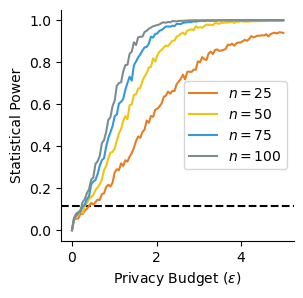

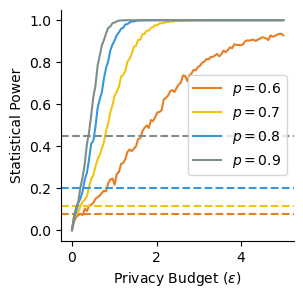

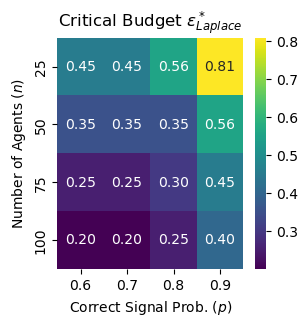

In [21]:
def binary_signals_statistical_power_laplace(n, p, epsilon, alpha=0.05, num_iters=5000):

    Delta = np.abs(np.log((1 - p) / p))

    # calculate LRT under H0
    LRTs_H0 = np.zeros(num_iters)
    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, 1 - p)

        LRTs_H0[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    threshold = np.percentile(LRTs_H0, 100 * (1 - alpha))

    LRTs_HA = np.zeros(num_iters)

    for i in range(num_iters):
        noise = np.random.laplace(0, 2 * Delta / epsilon, size=(n, 2))

        T = np.random.binomial(n, p)

        LRTs_HA[i] = T * np.log(p / (1 - p)) + (n - T) * np.log((1 - p) / p) + (noise[:, 0] - noise[:, 1]).sum()

    power = (LRTs_HA > threshold).mean()
    return power

def decision_threshold_laplace(n, p, alpha=0.05):
    epsilons = np.linspace(0, 5, 100)

    powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon) for epsilon in epsilons])

    threshold = np.argmin(np.abs(binary_signal_statistical_power_individual(p, alpha) - powers))

    return epsilons[threshold]

def plot_decision_thresholds_laplace():
    
    n_range = [25, 50, 75, 100]
    p_range = [0.6, 0.7, 0.8, 0.9]

    decision_thresholds = np.zeros(shape=(len(n_range), len(p_range)))

    for i, n in enumerate(n_range):
        for j, p in enumerate(p_range):
            decision_thresholds[i, j] = decision_threshold_laplace(n, p, alpha=0.05)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.heatmap(decision_thresholds, ax=ax, annot=True, fmt='.2f', cmap='viridis')

    ax.set_xticklabels(p_range)
    ax.set_yticklabels(n_range)

    ax.set_xlabel('Correct Signal Prob. ($p$)')
    ax.set_ylabel('Number of Agents ($n$)')

    ax.set_title('Critical Budget $\epsilon^*_{Laplace}$')

    fig.savefig('figures/decision_thresholds_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_n_laplace(p, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color='black')

    n_range = [25, 50, 75, 100]

    for i, n in enumerate(n_range):

        epsilons = np.linspace(0, 5, 100)

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$n = {n}$', color=palette[i])    

    sns.despine()

    ax.legend()

    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_n_laplace.pdf', bbox_inches='tight')

def binary_signals_curve_p_laplace(n, alpha=0.05):
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    p_range = [0.6, 0.7, 0.8, 0.9]
    epsilons = np.linspace(0, 5, 100)


    for i, p in enumerate(p_range):

        powers = np.array([binary_signals_statistical_power_laplace(n, p, epsilon, alpha) for epsilon in epsilons])

        ax.plot(epsilons, powers, label=f'$p  = {p}$', color=palette[i])

        ax.axhline(binary_signal_statistical_power_individual(p, alpha), linestyle='--', color=palette[i])

    sns.despine()

    ax.legend()


    ax.set_xlabel('Privacy Budget ($\\varepsilon$)')
    ax.set_ylabel('Statistical Power')

    fig.savefig('figures/binary_signals_curve_p_laplace.pdf', bbox_inches='tight')

binary_signals_curve_n_laplace(0.7)
binary_signals_curve_p_laplace(100)

plot_decision_thresholds_laplace()
